# Recommender System and User Profiler for Article Recommendation


### Importing essential packages used in this notebook


In [1]:
import numpy as np
import pandas as pd
from random import randint
import os
# The following packages are required for the LDA modeling used in this project
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import models
from gensim.matutils import cossim
from pprint import pprint
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Accessing the corpus and the document contents

The corpus has been created using articles from the NDTV news website. 

NDTV was chosen as our source as it scored the highest on our formula for the "top sources". The formula we used as part of our preliminary analysis was **Score = Normalized visits x Avg. visit duration x Pages per visit x Retention rate**

The articles are all in English, and the corpus has been cleaned of irrelevant content including those from ads. The corpus also includes the number of words in each of the article.

In [2]:
# Reading the corpus from local directory
data = pd.read_csv('D:/IISER/Bio-Major/Machine_learning/new_corpus_cleaned.csv',error_bad_lines = False)

# Visualization of the data
data

,Article_ID,Title,Text,Summary,Keywords,Number_of_words
0,1,"""I Floated Inside"": Man Returns To Site Of UFO...",Calvin Parker stands with family members at th...,The two had gone fishing after work at an aban...,"['abduction', 'men', 'post', 'sheriffs', 'saw'...",777
1,2,Chennai's Water Crisis Largely A Man-Made Disa...,"One of India's largest cities, Chennai, is dea...","One of India's largest cities, Chennai, is dea...","['india', 'largely', 'rivers', 'crisis', 'citi...",786
2,3,Haryana Congress Leader Killed Outside Gym Nea...,Vikas Chaudhary was attacked outside a gym in ...,Vikas Chaudhary was attacked outside a gym in ...,"['haryana', 'killed', 'leader', 'men', 'chaudh...",388
3,4,Nirav Modi To Appear For UK Court Hearing Via ...,India has requested the UK for extraditing PNB...,India has requested the UK for extraditing PNB...,"['india', 'appear', 'prison', 'magistrates', '...",495
4,5,Toddler Drowns After Falling In Bathtub At Hom...,The incident took place when the child was alo...,The incident took place when the child was alo...,"['took', 'toddler', 'place', 'mother', 'bathtu...",169
...,...,...,...,...,...,...
6959,6960,"Navjot Sidhu ""Probably"" Wants To Become Chief ...",Tensions between Amarinder Singh and Navjot Si...,Tensions between Amarinder Singh and Navjot Si...,"['wants', 'singh', 'navjot', 'mr', 'probably',...",539
6960,6961,"Odisha Matric Result Not Tomorrow, Confirms Board",Odisha 10th result date and time is yet to be ...,Odisha 10th result date and time is yet to be ...,"['results', 'board', 'exam', 'date', 'tomorrow...",218
6961,6962,"Stop ""Telecast"" Of PM Modi's Visits To Shrines...",Chandrababu Naidu also took on the Election Co...,Chandrababu Naidu also took on the Election Co...,"['visits', 'prime', 'body', 'visit', 'election...",463
6962,6963,BJP Candidate Claims Trinamool Placed Special ...,"Anupam Hazra, BJP candidate from Kolkata, said...","Anupam Hazra, BJP candidate from Kolkata, said...","['candidate', 'placed', 'special', 'election',...",410


In [3]:
# Accessing the text of the articles from the corpus
documents = pd.DataFrame(data[['Text','Article_ID']])
documents

,Text,Article_ID
0,Calvin Parker stands with family members at th...,1
1,"One of India's largest cities, Chennai, is dea...",2
2,Vikas Chaudhary was attacked outside a gym in ...,3
3,India has requested the UK for extraditing PNB...,4
4,The incident took place when the child was alo...,5
...,...,...
6959,Tensions between Amarinder Singh and Navjot Si...,6960
6960,Odisha 10th result date and time is yet to be ...,6961
6961,Chandrababu Naidu also took on the Election Co...,6962
6962,"Anupam Hazra, BJP candidate from Kolkata, said...",6963


As we can see, the text from the articles is in a single string format, and not understandable by the machine. Therefore we need to process the data.

### Data pre-processing 

The following are the processing steps done on the data:
1. **Tokenization**: The text is split into indvidual words, they are standardised to lower case, punctuations are removed
2. Words lower than 3 characters are removed
3. **Stop words** are **removed** (Stop words are those words that are commonly used in all articles irrespective of the topics and are not helpful in the modeling)
4. The remaining words are **Lemmatized**: words are changed into first person and verbs are converted into present tense.
5. Lemmatized words are then **Stemmed**: reduced to root form.

The above steps help us in standardizing the text from all articles and then used as an input for modeling.

In [4]:
# The following function is defined to lemmatize and stem the tokenized words
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# The following function is defined to process the data as a whole.
# The above defined function helps to make this code simpler!
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

The following code helps us look at how the text gets processed.

Here, we take **(Article_ID = 2138)** as an example.

In [5]:
doc_sample = documents[documents['Article_ID'] == 2138].values[0][0]

# The tokenized version of the document
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)

# The processed version of the document
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Karisma', 'Kapoor', 'shared', 'this', 'picture.', '(Image', 'courtesy:', 'therealkarismakapoor)\n\nHighlights', 'Karisma', "Kapoor's", 'post', 'received', 'over', '1', 'lakh', 'likes', 'on', 'Instagram\n\nThe', 'Kapoors', 'are', 'currently', 'on', 'a', 'vacation', 'in', 'Europe\n\nKarisma', 'shared', 'a', 'picture', 'from', 'their', 'vacation', 'on', 'Instagram\n\nKareena', 'Kapoor', 'managed', 'to', 'scoop', 'some', 'time', 'off', 'her', 'busy', 'schedule', 'and', 'is', 'currently', 'on', 'a', 'vacation', 'in', 'Europe', 'along', 'with', 'her', 'son', 'Taimur,', 'her', 'sister', 'Karisma', 'Kapoor', 'along', 'with', 'her', 'daughter', 'Samaira', 'and', 'son', 'Kiaan', 'Raj', 'Kapoor.', 'The', 'sister', 'duo', 'can', 'be', 'seen', 'happily', 'posing', 'for', 'the', 'camera', 'in', 'the', 'picture.', 'Kareena,', 'carrying', 'Taimur', 'in', 'her', 'arms,', 'looks', 'pretty', 'in', 'a', 'white', 'sweatshirt', 'while', 'Karisma', 'can', 'be', 'seen', 'wearing', 'a', '

The entire corpus is preprocessed and the resulting bag of words contains the word and the number of times it appears in the training set.

In [6]:
# Pre-processing the entire corpus of documents
processed_docs = documents['Text'].map(preprocess)

Filtering of these generate tokens:
1. The tokens that appear in less **15 (integer)** of articles, we remove them from the considered dictionary as we deem them not useful for topic modeling.
2. The tokens that appear in more than **60% (0.6 in fraction)** of documents are also deemed as stop words and therfore not useful in topic modeling and removed from the dictionary

After the edits are done, the top 100000 most frequent tokens are retained as input for modeling.

In [7]:
dictionary = gensim.corpora.Dictionary(processed_docs)
# The filtering done for tokens.
dictionary.filter_extremes(no_below=15, no_above=0.6, keep_n = 1000000)

# The length of the filtered dictionary.
len(dictionary)

5533

A dictionary is created for each document that reports the words from the filtered tokens and how many times it appears in that document. This is then saved as another corpus named *bow_corpus*.

In [8]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Looking at the example output of the bow_corpus
bow_doc_2138 = bow_corpus[2137]
for i in range(len(bow_doc_2138)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_2138[i][0], dictionary[bow_doc_2138[i][0]],bow_doc_2138[i][1]))

Word 6 ("arm") appears 1 time.
Word 23 ("camera") appears 1 time.
Word 74 ("hand") appears 2 time.
Word 100 ("like") appears 2 time.
Word 104 ("look") appears 2 time.
Word 108 ("media") appears 1 time.
Word 113 ("news") appears 1 time.
Word 127 ("post") appears 2 time.
Word 149 ("see") appears 4 time.
Word 160 ("stori") appears 2 time.
Word 166 ("talk") appears 1 time.
Word 173 ("time") appears 1 time.
Word 188 ("work") appears 1 time.
Word 191 ("year") appears 1 time.
Word 198 ("alongsid") appears 1 time.
Word 210 ("busi") appears 2 time.
Word 276 ("includ") appears 1 time.
Word 277 ("india") appears 1 time.
Word 292 ("manag") appears 1 time.
Word 332 ("receiv") appears 2 time.
Word 344 ("ride") appears 1 time.
Word 348 ("share") appears 4 time.
Word 355 ("soon") appears 1 time.
Word 464 ("walk") appears 1 time.
Word 491 ("current") appears 2 time.
Word 509 ("good") appears 1 time.
Word 515 ("judg") appears 1 time.
Word 524 ("london") appears 1 time.
Word 576 ("video") appears 1 time.

### Transformation

The elements of the *bow_corpus* is given a **TF-IDF** value. This is done so as to give a numerical value to the bag of words.

In [9]:
# TF-IDF model saved into the variable tfidf_model and run on the bow_corpus
tfidf_model = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf_model[bow_corpus]

# Example for the transformation of Article_ID 2138:
pprint(corpus_tfidf[2137])

[(6, 0.03875080261083998),
 (23, 0.04451676628778302),
 (74, 0.054745060994075306),
 (100, 0.030757661250447155),
 (104, 0.0436141629266857),
 (108, 0.021217980294323882),
 (113, 0.016007298304669935),
 (127, 0.03619972195001879),
 (149, 0.08590932756078559),
 (160, 0.06678127361348346),
 (166, 0.026683127203066412),
 (173, 0.012074431239422914),
 (188, 0.01602707715653658),
 (191, 0.007256576602501354),
 (198, 0.05222889789004198),
 (210, 0.062464735577081286),
 (276, 0.015107230579236436),
 (277, 0.016260322754562507),
 (292, 0.028086468996047696),
 (332, 0.05181789758159793),
 (344, 0.05281694665373828),
 (348, 0.08582548779054872),
 (355, 0.029004673808012353),
 (464, 0.040050611967180884),
 (491, 0.05595315088462584),
 (509, 0.02684758477425849),
 (515, 0.04010162516937271),
 (524, 0.04078575912663814),
 (576, 0.0285557461444862),
 (588, 0.03085379103637251),
 (622, 0.09886845981985762),
 (657, 0.04041244127451203),
 (670, 0.03087709832777418),
 (845, 0.027372530497037653),
 (876,

### Model

In this project, **Latent Dirichlet Allocation** (LDA) is used for modeling. It is the algorithm for topic modeling of the news articles. The model is trained on the corpus and used against the corpus to provide a topic based recommender system.

Here, the LDA model is trained using the bag of words.
- Number of topics set to **12**, the value chosen based on the suggestion from the journalists we talked to as part of our preliminary analysis.
- Number of passes is set to **3**, it is the number of times the model goes through the corpus for training. 
- Number of workers set to **3**, it is one less than the number of cores present on the computer.

*Note: 
There is no set method to finalize on the number of topics and number of passes. The best possible scenario has been genereated using a trial and error method, where a bunch of random articles were selected from the corpus and checked for similarity to the topic through human intervention*

LDA model is chosen as topic based recommendation is the idea behind this recommender system.

In [10]:
# Training of the model
lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=12, id2word=dictionary, passes=3, workers=2)

Since this is unsupervised learning, the topics are just groups of words that define an important classification. We can later go through the words and name each topic, if neccessary.

The following is the visualization of the topics got from our corpus.

In [11]:
# The topics as defined by the model
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.006*"court" + 0.003*"case" + 0.003*"polic" + 0.003*"india" + 0.003*"minist" + 0.003*"modi" + 0.002*"lanka" + 0.002*"terror" + 0.002*"attack" + 0.002*"cyclon"
Topic: 1 
Words: 0.005*"congress" + 0.005*"gandhi" + 0.005*"minist" + 0.005*"parti" + 0.004*"delhi" + 0.004*"everest" + 0.004*"modi" + 0.003*"elect" + 0.003*"climber" + 0.003*"poll"
Topic: 2 
Words: 0.015*"polic" + 0.007*"arrest" + 0.006*"woman" + 0.005*"hospit" + 0.005*"accus" + 0.005*"allegedli" + 0.005*"station" + 0.004*"incid" + 0.004*"doctor" + 0.004*"girl"
Topic: 3 
Words: 0.006*"polic" + 0.005*"sidhu" + 0.003*"singh" + 0.003*"earthquak" + 0.003*"amarind" + 0.003*"case" + 0.002*"navjot" + 0.002*"ysrcp" + 0.002*"incid" + 0.002*"parti"
Topic: 4 
Words: 0.009*"elect" + 0.009*"modi" + 0.009*"parti" + 0.007*"seat" + 0.007*"minist" + 0.007*"poll" + 0.006*"congress" + 0.006*"vote" + 0.005*"sabha" + 0.005*"prime"
Topic: 5 
Words: 0.013*"result" + 0.010*"congress" + 0.007*"gandhi" + 0.007*"elect" + 0.007*"parti" + 

**Checking the model:**

The model is checked against the example article (**Article_ID = 2138**).

In [12]:
for index, score in sorted(lda_model[bow_corpus[2137]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.8174107670783997	 
Topic: 0.009*"film" + 0.004*"kapoor" + 0.004*"pictur" + 0.004*"share" + 0.003*"instagram" + 0.003*"khan" + 0.003*"actor" + 0.003*"post" + 0.003*"video" + 0.003*"look"

Score: 0.17703095078468323	 
Topic: 0.005*"china" + 0.004*"trade" + 0.004*"chines" + 0.004*"india" + 0.003*"huawei" + 0.003*"trump" + 0.003*"diet" + 0.003*"tariff" + 0.003*"compani" + 0.003*"protein"


This shows the topic distribution of the article. We access this data, and create a dataframe to do the clustering algorithm using K Means Method. This clustering is done so as to create clusters of articles based on their topic similarity. The articles are vectorized based on their topic distribution. 

In [13]:
lda_model[bow_corpus][2137]

[(6, 0.817421), (8, 0.17702068)]

### Visualizing the LDA corpus

In [14]:
import pyLDAvis.gensim

In [15]:
pyLDAvis.enable_notebook()

In [16]:
pyLDAvis.gensim.prepare(lda_model, corpus_tfidf, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.038437 -0.023813       1        1  19.319803
4     -0.094214  0.088422       2        1  14.974506
2      0.096031 -0.006492       3        1  11.166348
0      0.013419  0.019172       4        1  10.302356
11     0.029189  0.010004       5        1   7.902119
7     -0.063406 -0.150329       6        1   7.181273
10     0.035448  0.022292       7        1   7.171018
8      0.009779  0.018383       8        1   6.009141
5     -0.113701 -0.007051       9        1   5.613420
1     -0.040992  0.037310      10        1   4.394920
9      0.059651 -0.007313      11        1   4.004579
3      0.030361 -0.000585      12        1   1.960523, topic_info=           Term        Freq       Total Category  logprob  loglift
342      result  120.000000  120.000000  Default  30.0000  30.0000
126       polic  156.000000  156.000000  Default  29.0000  29.0000
403    congress  111.000000  111.000000  Default  28.0000  28.0000
1396       exam   55.000000   55.000000  Default  27.0000  27.0000
719       elect  122.000000  122.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1884       vote    1.803016   74.071281  Topic12  -6.2741   0.2164
640      offici    1.700622   73.434402  Topic12  -6.3326   0.1666
1425  allegedli    1.644486   44.842812  Topic12  -6.3662   0.6262
430      minist    1.676453  124.217102  Topic12  -6.3469  -0.3734
592        girl    1.634923   49.563053  Topic12  -6.3720   0.5203

[777 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3027      1  0.852089     aamir
3437      7  0.578120  abdullah
3437     10  0.144530  abdullah
3073      1  0.082386    academ
3073      5  0.082386    academ
...     ...       ...       ...
2689     12  0.404103     ysrcp
3146      1  0.193996     zarif
3146      2  0.193996     zarif
3146      5  0.581988     zarif
3146      8  0.193996     zarif

[3173 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 3, 1, 12, 8, 11, 9, 6, 2, 10, 4])

## Optimization for LDA topic number:

Optimization using coherence method. Coherence method is a denotion of human interpretability of the topics, therefore a good metric to optimize our model.

In [42]:
def evaluate_graph(dictionary, corpus, texts, limit):
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = gensim.models.CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

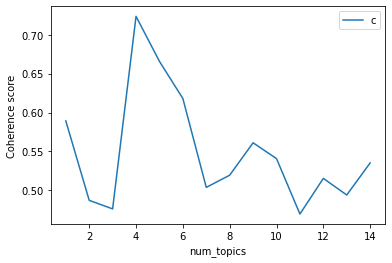

Wall time: 11min 43s


In [43]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus_tfidf, texts=processed_docs, limit=15)

In [49]:
pyLDAvis.gensim.prepare(lmlist[4], corpus_tfidf, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.013994  0.051141       1        1  28.018337
4      0.098745  0.034656       2        1  24.953259
2     -0.069044  0.027254       3        1  22.239552
3      0.034746 -0.098278       4        1  18.115463
1     -0.078441 -0.014773       5        1   6.673393, topic_info=          Term        Freq       Total Category  logprob  loglift
342     result  160.000000  160.000000  Default  30.0000  30.0000
1884      vote  101.000000  101.000000  Default  29.0000  29.0000
403   congress  127.000000  127.000000  Default  28.0000  28.0000
797       seat  118.000000  118.000000  Default  27.0000  27.0000
719      elect  145.000000  145.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
2713   contest    8.783077   37.653259   Topic5  -5.9157   1.2514
427     leader    9.416029   72.373695   Topic5  -5.8461   0.6676
646    pradesh    9.103024   66.898064   Topic5  -5.8799   0.7125
400      chief    8.727534   79.605942   Topic5  -5.9220   0.4964
2186      cent    8.608538   51.846802   Topic5  -5.9357   0.9115

[349 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1999      2  0.164530  abort
1999      5  0.658119  abort
194       1  0.611619  accus
194       2  0.099182  accus
194       3  0.247954  accus
...     ...       ...    ...
1091      5  0.026618  write
4385      1  0.250117  yadav
4385      2  0.025012  yadav
4385      3  0.675317  yadav
4385      5  0.025012  yadav

[942 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 4, 2])

In [50]:
lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=5, id2word=dictionary, passes=3, workers=2)

### Clustering the article using KMeans method

We create the a vector space based on the topic distribution, and then we check the best possible K for our vector using the Elbow method, and continue clustering with that.

In [51]:
# Creating a dataframe to conduct kmeans clustering.
no_articles = len(data['Article_ID'])
dimension = 5 # based on optimized value
array_vectors = np.zeros((no_articles,dimension))
for i in range(no_articles):
    for j in lda_model[bow_corpus][i]:
        array_vectors[i][j[0]] = j[1]
        
lda_model_kmeans_df = pd.DataFrame(array_vectors)

# Visulaizing the data
lda_model_kmeans_df    

,0,1,2,3,4
0,0.269517,0.000000,0.471086,0.000000,0.257868
1,0.414768,0.000000,0.578818,0.000000,0.000000
2,0.000000,0.000000,0.256039,0.000000,0.738443
3,0.945846,0.000000,0.000000,0.000000,0.051577
4,0.000000,0.000000,0.000000,0.000000,0.989304
...,...,...,...,...,...
6959,0.000000,0.054439,0.943220,0.000000,0.000000
6960,0.000000,0.000000,0.000000,0.992264,0.000000
6961,0.159413,0.704957,0.000000,0.133935,0.000000
6962,0.221832,0.640223,0.000000,0.135864,0.000000


In [52]:
# Optimizing K value.
from sklearn import metrics 
from scipy.spatial.distance import cdist

In [53]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,16) 
X = lda_model_kmeans_df
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_

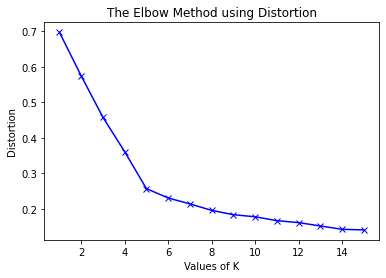

In [54]:
#visualizing using distortion 
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

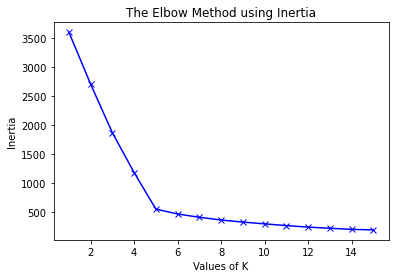

In [55]:
# Visualizing using inertia
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

##### Conducting clustering for the above derived vectors. We can see that the elbow is forming around 5 clusters. So we choose 5 as the final cluster value.

In [56]:
kmeans_lda_model = KMeans(n_clusters=5)
model_1 = kmeans_lda_model.fit(lda_model_kmeans_df)

In [57]:
model_1.cluster_centers_

array([[0.0843034 , 0.77399546, 0.05434988, 0.04542455, 0.0372536 ],
       [0.06911453, 0.03356085, 0.04412545, 0.03412819, 0.81193161],
       [0.07069952, 0.06867918, 0.75911054, 0.02782709, 0.06944295],
       [0.04350032, 0.02672113, 0.02305105, 0.8716529 , 0.0295435 ],
       [0.77947509, 0.0539863 , 0.0481435 , 0.04625652, 0.06791079]])

In [59]:
# Calculating the number of articles present in each of the clusters.
cluster_values = dict()
for cluster in model_1.labels_:
    cluster_values[cluster] = cluster_values.get(cluster,0) + 1
    
cluster_values

{2: 1140, 1: 1577, 4: 1855, 0: 1460, 3: 932}

In [60]:
# Creating an association of the article id with cluster.
list_of_articleid_and_cluster = list()
for i in range(len(model_1.labels_)):
    list_of_articleid_and_cluster.append((i+1,model_1.labels_[i]))
    
list_of_articleid_and_cluster

[(1, 2),
 (2, 2),
 (3, 1),
 (4, 4),
 (5, 1),
 (6, 0),
 (7, 4),
 (8, 1),
 (9, 1),
 (10, 4),
 (11, 1),
 (12, 2),
 (13, 4),
 (14, 4),
 (15, 3),
 (16, 1),
 (17, 4),
 (18, 1),
 (19, 3),
 (20, 1),
 (21, 3),
 (22, 3),
 (23, 1),
 (24, 4),
 (25, 0),
 (26, 4),
 (27, 1),
 (28, 4),
 (29, 0),
 (30, 4),
 (31, 4),
 (32, 2),
 (33, 4),
 (34, 1),
 (35, 4),
 (36, 0),
 (37, 4),
 (38, 0),
 (39, 4),
 (40, 4),
 (41, 4),
 (42, 4),
 (43, 4),
 (44, 4),
 (45, 4),
 (46, 4),
 (47, 1),
 (48, 4),
 (49, 4),
 (50, 2),
 (51, 1),
 (52, 3),
 (53, 2),
 (54, 2),
 (55, 1),
 (56, 4),
 (57, 1),
 (58, 1),
 (59, 4),
 (60, 2),
 (61, 1),
 (62, 4),
 (63, 0),
 (64, 4),
 (65, 4),
 (66, 2),
 (67, 0),
 (68, 4),
 (69, 1),
 (70, 0),
 (71, 1),
 (72, 1),
 (73, 3),
 (74, 0),
 (75, 4),
 (76, 3),
 (77, 1),
 (78, 4),
 (79, 2),
 (80, 0),
 (81, 0),
 (82, 0),
 (83, 1),
 (84, 2),
 (85, 3),
 (86, 0),
 (87, 1),
 (88, 0),
 (89, 1),
 (90, 0),
 (91, 4),
 (92, 3),
 (93, 4),
 (94, 3),
 (95, 1),
 (96, 4),
 (97, 4),
 (98, 2),
 (99, 1),
 (100, 1),
 (101, 0

In [61]:
# Isolating the Article_IDs based on the cluster, here it is stored as a dictionary
dictionary_of_articleid = {'0':list(),'1': list(),'2':list(),'3':list(),'4':list()}

for i in range(len(list_of_articleid_and_cluster)):
    dictionary_of_articleid[str(list_of_articleid_and_cluster[i][1])].append(list_of_articleid_and_cluster[i][0])
    
dictionary_of_articleid

{'0': [6,
  25,
  29,
  36,
  38,
  63,
  67,
  70,
  74,
  80,
  81,
  82,
  86,
  88,
  90,
  101,
  104,
  108,
  109,
  111,
  122,
  125,
  132,
  139,
  141,
  152,
  157,
  163,
  164,
  167,
  176,
  183,
  202,
  210,
  215,
  237,
  239,
  241,
  243,
  250,
  253,
  258,
  259,
  262,
  277,
  278,
  282,
  285,
  288,
  293,
  297,
  305,
  313,
  316,
  321,
  328,
  332,
  334,
  335,
  345,
  358,
  366,
  371,
  400,
  404,
  410,
  415,
  418,
  420,
  430,
  433,
  435,
  451,
  463,
  465,
  470,
  472,
  474,
  475,
  484,
  486,
  492,
  494,
  498,
  501,
  504,
  505,
  506,
  509,
  514,
  517,
  523,
  527,
  530,
  537,
  541,
  543,
  548,
  556,
  573,
  575,
  578,
  579,
  580,
  585,
  591,
  598,
  611,
  620,
  625,
  632,
  640,
  641,
  644,
  645,
  647,
  649,
  651,
  657,
  660,
  661,
  662,
  665,
  666,
  673,
  676,
  677,
  678,
  683,
  684,
  685,
  692,
  693,
  695,
  699,
  700,
  719,
  721,
  723,
  727,
  728,
  747,
  760,
  769,
  7

## Recommendation system:

In [62]:
# Checking for recommendations:
recommendation_list_articles = list()
for i in dictionary_of_articleid.keys():
    recommendation_list_articles.append(np.random.choice(dictionary_of_articleid[i], replace = False))
    
recommendation_list_articles

[5986, 2596, 1266, 5951, 5163]

In [63]:
# Generating cossim matrix to store cosine simmiarity value
# cossim_matrix = np.zeros(shape=(len(data['Article_ID']),len(data['Article_ID'])))
# Generation of cossim_matrix is time consuming, we are importing an already evaluated matrix
cossim_matrix = np.load('D:/IISER/Bio-Major/Machine_learning/cossim_matrix_savefile.npy')

In [64]:
# Cold Start
article_id_to_display = list()
Cluster_values_value = list()
for i in cluster_values.keys():
    Cluster_values_value.append(cluster_values[i])
cluster_probability = list()  # Based on the cluster size
for i in Cluster_values_value:
    cluster_probability.append(i/sum(Cluster_values_value))
for i in range(10):
    cluster_choice = np.random.choice(range(0,5),replace = False, p = cluster_probability)
    article_id = np.random.choice(dictionary_of_articleid[str(cluster_choice)], replace = False)
    article_id_to_display.append(article_id)
    
# article_id_to_display
get_corp = lda_model[bow_corpus]
recommend = pd.DataFrame(columns = ['Article_ID', 'Title'])

for i in article_id_to_display:
    index = i - 1
    recommend = recommend.append({'Article_ID': data['Article_ID'][index], 'Title':data['Title'][index]}, ignore_index = True)
    
print(recommend['Title'])
article_id_to_not_display_again = list()

print('Enter the rank of article or enter quit to exit')

article_to_read = input('Enter the rank of article you wish to read: ')

article_id_to_not_display_again.append(int(data['Article_ID'][recommend['Article_ID'][int(article_to_read)]-1])) # index of article to not display again
print('')
print('Title: ')
print(data['Title'][recommend['Article_ID'][int(article_to_read)]-1])
print('')
print('Article:')
print(data['Text'][recommend['Article_ID'][int(article_to_read)]-1])

print('')
print('Enter back to see next set of articles or quit to exit !!')
next_article = input('Enter your choice: ')
print('')
while next_article != 'quit':
    current_article_index = recommend['Article_ID'][int(article_to_read)] - 1
    article_id_to_not_display_again.append(current_article_index)
    top_recos = list()
    for i in range(len(get_corp)):
        if i == article_to_read or i in article_id_to_not_display_again:
            continue
        if len(top_recos) < 5:
            top_recos.append((cossim_matrix[current_article_index][i], i))
            top_recos = sorted(top_recos)
        if cossim_matrix[current_article_index][i] > top_recos[0][0]:
            top_recos.pop(0)
            top_recos.append((cossim_matrix[current_article_index][i], i))
            top_recos = sorted(top_recos)
    
    top_recos = sorted(top_recos,reverse = True)
    article_id_to_display = list()
    for i in top_recos:
        article_id_to_display.append(int(i[1])+1)
    Cluster_values_value = list()
    for i in cluster_values.keys():
        Cluster_values_value.append(cluster_values[i])
    cluster_probability = list()  # Based on the cluster size
    for i in Cluster_values_value:
        cluster_probability.append(i/sum(Cluster_values_value))
    for i in range(5):
        cluster_choice = np.random.choice(range(0,5),replace = False, p = cluster_probability)
        article_id = np.random.choice(dictionary_of_articleid[str(cluster_choice)], replace = False)
        article_id_to_display.append(article_id)
        
    recommend = pd.DataFrame(columns = ['Article_ID', 'Title'])
    for i in article_id_to_display:
        index = i - 1
        recommend = recommend.append({'Article_ID': data['Article_ID'][index], 'Title':data['Title'][index]}, ignore_index = True)
    
    print(recommend['Title'])
    
    print('Enter the rank of article or enter quit to exit')
    print('')
    article_to_read = input('Enter the rank of article you wish to read: ')
    if article_to_read == 'quit': break
    
    article_id_to_not_display_again.append(int(data['Article_ID'][recommend['Article_ID'][int(article_to_read)]-1])) # index of article to not display again
    print('')
    print('Title: ')
    print(data['Title'][recommend['Article_ID'][int(article_to_read)]-1])
    print('')
    print('Article:')
    print(data['Text'][recommend['Article_ID'][int(article_to_read)]-1])
    print('')
    print('Enter back to see next set of articles or quit to exit !!')
    next_article = input('Enter your choice: ')
    if next_article == 'quit': break
    print('')
    

print('Thank you for using our recommender system!!!!!!!!!!!')


0    Pramod Sawant Makes His Mark In BJP's Post Par...
1            Delhi University First Cut-Off On June 28
2    Karnataka Forms Cabinet Sub-Committee On Sale ...
3    Broadcast Engineering Consultants India Ltd (B...
4    Salman's Biceps As Big As His Box Office: Shob...
5    After RJD Gets No Seats, Party Lawmaker Asks T...
6    Drunk Indian Man Jailed For Assaulting Police ...
7    Temperatures In Kuwait, Pak Third And Fourth H...
8    Once A Medical Aspirant, Odisha Teacher Now He...
9    2 Former Top Executives Arrested In IL&FS Mone...
Name: Title, dtype: object
Enter the rank of article or enter quit to exit
Enter the rank of article you wish to read: 1

Title: 
Delhi University First Cut-Off On June 28

Article:
Delhi University announced its revised admission schedule Wednesday.

National Capital Region-based Delhi University or DU will release the first cut-off for admission to various undergraduate (UG) courses in its colleges on June 28, according to the revised admission

## HDA Model:

HDA stand for Hierarchical Dirichlet Allocation (a.k.a Hierarchical Dirichlet Process (HDP)). It is a non-parametric Bayesian approach to cluster grouped data. This algorithm identifies the number of topics in the corpus and then clusters the articles.

We are using this as an alternate approach as we feel that the our diverse corpus might have more than the assumed number of topics. This process will help with better clustering of the data.

In [65]:
# Importing the required package to run the HDP model.
from gensim.models import HdpModel

In [66]:
hdp = HdpModel(bow_corpus,dictionary)

In [67]:
# The topics as defined by the model
for idx, topic in hdp.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

In [68]:
hdp.get_topics().shape

(150, 5533)

The HDP identified the number of topics in the corpus to be **150**!

*Note: The value is much higher than our assumption, implying that the model requires further tweaking!*

In [69]:
# Creating an array of the hdp topic vectors
no_articles = len(data['Article_ID'])
array_vectors_hdp = np.zeros((no_articles,hdp.get_topics().shape[0]))
for i in range(no_articles):
    for j in hdp[bow_corpus][i]:
        array_vectors_hdp[i][j[0]] = j[1]
hdp_df = pd.DataFrame(array_vectors_hdp)
# Visualizing the dataframe.
hdp_df

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,0.111487,0.000000,0.000000,0.0,0.644478,0.121878,0.0,0.055285,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.063571,0.000000,0.0,0.000000,0.000000,0.0,0.931748,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.428563,0.000000,0.000000,0.0,0.000000,0.569112,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.492133,0.000000,0.000000,0.0,0.000000,0.506245,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.014947,0.000000,0.000000,0.0,0.000000,0.979974,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6959,0.963932,0.034861,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6960,0.000000,0.000000,0.988467,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6961,0.998239,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6962,0.997848,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# K-means clustering of the hdp model.
kmeans_hdp = KMeans(n_clusters=12)
model_2 = kmeans_hdp.fit(hdp_df)

# Creating a dictionary for getting the topics

list_of_articleid_and_cluster_hdp = list()
for i in range(len(model_2.labels_)):
    list_of_articleid_and_cluster_hdp.append((i+1,model_2.labels_[i]))
    
# Isolating the Article_IDs based on the cluster, here it is stored as a dictionary
dictionary_of_articleid_hdp = {'0':list(),'1': list(),'2':list(),'3':list(),'4':list(),'5':list(),'6': list(),'7': list(),'8': list(),'9': list(),'10':list(),'11': list()}

for i in range(len(list_of_articleid_and_cluster_hdp)):
    dictionary_of_articleid_hdp[str(list_of_articleid_and_cluster_hdp[i][1])].append(list_of_articleid_and_cluster_hdp[i][0])
    
dictionary_of_articleid_hdp

In [ ]:
# Calculating the number of articles present in each of the clusters.
hdp_cluster_values = dict()
for cluster in model_2.labels_:
    hdp_cluster_values[cluster] = hdp_cluster_values.get(cluster,0) + 1
    
hdp_cluster_values

In [ ]:
for i in range(5):
    article_id_choice = np.random.choice(dictionary_of_articleid['1'], replace = False)
    print(article_id_choice)

In [ ]:
cossim(hdp[bow_corpus][234],hdp[bow_corpus][4791])

In [ ]:
recommendation_list_articles_hdp = list()
for i in dictionary_of_articleid_hdp.keys():
    recommendation_list_articles_hdp.append(np.random.choice(dictionary_of_articleid_hdp[i], replace = False))
    
recommendation_list_articles_hdp

### User Profile Generation

The user profile is generated from the corpus using a markov chain, based on the cosine similarity between the topics. The start topic for each user is randomized and the follwoing articles are generated by travel through the chain.

Here are the assumptions taken into consideration:
- The user reads the whole article.
- The user doesnt read the same article twice.
- The reading speed of every user is comparable.

The cosine similarities are used as arguments to generate the transition matrix.

In [ ]:
# A matrix is defined to collect the cosine similarities between every pair of articles
cossim_matrix = np.zeros(shape=(len(data['Article_ID']),len(data['Article_ID'])))

get_corp = lda_model[bow_corpus]

for i in range(len(get_corp)):
    for j in range(len(get_corp)):
        cossim_matrix[i][j] = cossim(get_corp[i],get_corp[j])
        print('Done with',i,j)
        
# The matrix output is as follows
print('The cos-sine similarity values between the documents: \n',cossim_matrix)

In [ ]:
# The function is defined to arrive at transition probabilities based on the cosine similarity.
def normalize(matrix):
    # Defining a new  matrix with same dimensions as the input matrix
    norm = np.zeros((matrix.shape[0],matrix.shape[1]))
    
    # Making the values corresponding to same document 0 as the reader doesnt read the same article again
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if i==j:
                matrix[i][j] = 0
    # Normalizing the values to generate transition probabilities between documents
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            norm[i][j] = float(matrix[i][j])/sum(matrix[i])
            
    return norm

transition_matrix = normalize(cossim_matrix)
transition_matrix

**Node selection using transition probabilities**

The above transtion denotes transition probabilities in the following manner:

The transition probability from document at index i ( *$d_i$* ) [**Node 1**] is given by the 1-D array *transition_matrix[i]* ( **$tp_i$** ) .  
Document **$d_{i+1}$** [**Node 2**] is then chosen using the using $tp_i$

For example, consider the document being considered is at **index = 69** , the following is the code for choosing the next article.

In [ ]:
index_of_next_article = np.random.choice(transition_matrix.shape[1], replace = False, p=transition_matrix[69])
print('The next article is at index = ', index_of_next_article)

The main data consists of a column **'Number_of_words'** denoting the number of words in the article. This can be used to generate a probable reading time.  

The proposed user profile will contain the following parameters:
- **User_ID** : The user number
- **Session_ID** : Reading an article is considered as a session, starts at 1 with every new User_ID
- **Article_Rank** : As seen in the recommender which suggests 10 articles every time, here it is created using randint
- **Article_ID** : The ID of the article being read
- **Time_Spent** : The amount of time spent in reading that article, to be recorded in seconds.

The total time spent is based on the probabilities that we understood from our survey among our peers.  

We understood that majority of the people would spend between 15 minutes and 60 minutes. Therefore the exact time spent by a person is said to be **normally distributed with mean time 40 minutes and standard deviation of 7 minutes**.   
(Why standard deviation = 7 minutes? Answer: This would mean 99% of times we would generate a number between 15 and 60 minutes. Still not convinced?! Then it is a random distribution assumed by the coders based on intuition. :) )

Similarly for people reading for less than 5 minutes, the **normal distribution is defined with mean of 2.5 minutes and the standard deviation of 1 minute**, for those who spend 5 to 15 minutes a **normal distribution with mean of 10 minutes and std dev as 2 minutes**, and for those who read for more than 1 hour, it is considered to be a **normal distribution around mean of 90 minutes and standard deviation of 10 minutes**.

Based on our survey as carried out during the preliminary analysis, the following are observations on reading time:
- **7.1%** of the people spend **less than 5 minutes** in reading online news articles.
- **35.2%** of the people spend **between 5 and 15 minutes** reading online news articles.
- **42.6%** of the people spend **between 15 and 60 minutes** reading online news articles.
- **15.3%** of the people spend **more than 60 minutes** reading online news articles.

According to www.medium.com, the average reading time of an adult is about 265 words per minute. We assume the **reading time to be a normal distribution with the mean as 265 and the standard deviation of 10**. We use this normal distribution to fix the reading time for each user and decide the cutoff for number of articles read based on the probability of time we collected from our google doc.

A buffer time for each session has been set at 10s. This buffer time is for the user to go through the articles and then click one.

In [ ]:
# Empty dataframe created to accept values of the generated user profile.
user_profile = pd.DataFrame(columns=['User_ID','Session_ID','Article_Rank','Article_ID','Time_Spent'])

A user profile consisting of 100 users is created.

In [ ]:
user_number = 100
# If the code is used for custom number of users, then use user_number = int(input('Number of users required in profile: '))
for user in range(1,user_number+1): # Since User_ID starts from 1
    reading_speed = int(np.random.normal(265,10)//1) #integral value considered for ease of math
    total_time_spent_group = np.random.choice(['less than 5', '5 to 15','15 to 60', 'more than 60'],p=[0.071,0.352,0.426,0.151])
    #probabilities got from survey
    if total_time_spent_group == 'less than 5':
        total_time_spent = int(np.random.normal(2,0.5)//1)
        while total_time_spent <=0:
            total_time_spent = int(np.random.normal(2,0.5)//1)
            
    elif total_time_spent_group == '5 to 15':
        total_time_spent = int(np.random.normal(10,2)//1)
        while total_time_spent <=0:
            total_time_spent = int(np.random.normal(10,2)//1)
            
    elif total_time_spent_group == '15 to 60':
        total_time_spent = int(np.random.normal(40,7)//1)
        while total_time_spent <=0:
            total_time_spent = int(np.random.normal(40,7)//1)
            
    else :
        total_time_spent = int(np.random.normal(90,10)//1)
        while total_time_spent <=0:
            total_time_spent = int(np.random.normal(90,10)//1)
            
    index_of_current_article = randint(0,199)
    session_time_total = 0 #to set cutoff for user time.
    for session in range(1,1000):# assuming that the max number of articles read is 1000.
        session_time_total = session_total_time + 10 # buffer time
        article_rank = np.random.randint(1,10)
        article_id = data['Article_ID'][index_of_current_article]
        words_in_article = int(data['Number_of_words'][index_of_current_article])
        time_spent_in_minutes = round(words_in_article/reading_speed,2)
        session_time_total += time_spent_in_minutes
        time_spent_in_seconds = round(time_spent_in_minutes*60,0)
        user_profile = user_profile.append({'User_ID': user, 'Session_ID': session,'Article_Rank': article_rank,'Article_ID': article_id, 'Time_Spent': time_spent_in_seconds}, ignore_index=True)
        if session_time_total >= total_time_spent:
            break
        index_of_current_article = np.random.choice(transition_matrix.shape[1], replace = False, p=transition_matrix[index_of_current_article])
        continue
    continue

user_profile = user_profile.dropna(axis=1)
user_profile

## *fin.*

### Please feel free to reach out in case you would have any suggestions and/or questions!
